In [23]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%config InlineBackend.figure_format='retina'
import sympy as sy
from sympy import I as I
from sympy import pi as pi
import sympy.physics.quantum as qm
from sympy.physics.quantum import TensorProduct as kron
from sympy.physics.quantum import OuterProduct as outer
import ipywidgets

# 1Q gates

In [4]:
# Quantum states
ket1 = qm.state.OrthogonalKet(1)
ket0 = qm.state.OrthogonalKet(0)
bra1 = qm.state.OrthogonalBra(1)
bra0 = qm.state.OrthogonalBra(0)
kets = np.array([ket1,ket0])
bras = np.array([bra1,bra0])

In [5]:
# Matrices
iden = np.array([[1,0],[0,1]])
sigx = np.array([[0,1],[1,0]])
sigy = np.array([[0,-I],[I,0]])
sigz = np.array([[1,0],[0,-1]])

def qop(A):
    retval = 0
    if type(A) != sy.matrices.immutable.ImmutableDenseMatrix:
        for ii,row in enumerate(A):
            for jj,val in enumerate(row):
                    retval += val* kets[ii]*bras[jj]
    else:
        for idx, val in enumerate(A):
            ii = int(idx/2)
            jj = int(idx - ii*np.sqrt(len(A)))
            retval += val*  kets[ii]*bras[jj]
    return retval
        

I_ = qop(iden)
X  = qop(sigx)
Y  = qop(sigy)
Z  = qop(sigz)

In [6]:
Z

-|0><0| + |1><1|

In [7]:
def Rx(theta):
    return sy.simplify(sy.exp(-I*theta/2 * sy.Matrix(sigx)))

def Ry(theta):
    return sy.simplify(sy.exp(-I*theta/2 * sy.Matrix(sigy)))

def Rz(phi):
    return sy.exp(-I*phi/2 * sy.Matrix(sigz))

def nhat(theta,phi): 
    return [sy.cos(phi)*sy.sin(theta), sy.sin(phi)*sy.sin(theta), sy.cos(theta)]

sigarrs = [sigx,sigy,sigz]
sigoper = [X,Y,Z]

def ndotsigma(theta,phi):
    rotax = nhat(theta,phi)
    retval = sy.Matrix.zeros(2)
    for comp,sig in zip(rotax,sigarrs):
        retval += comp*sig
    return retval

In [8]:
theta, phi = sy.symbols(r'\theta \phi', real=True)
# State with Bloch vector (r=1,theta,phi)
psi = qm.qapply(qop(Rz(phi)*Ry(theta))*ket1)

In [9]:
Rz(phi)*Ry(theta)

Matrix([
[exp(-I*\phi/2)*cos(\theta/2), -exp(-I*\phi/2)*sin(\theta/2)],
[ exp(I*\phi/2)*sin(\theta/2),   exp(I*\phi/2)*cos(\theta/2)]])

In [10]:
psi

exp(I*\phi/2)*sin(\theta/2)*|0> + exp(-I*\phi/2)*cos(\theta/2)*|1>

In [11]:
def sigphi(phi):
    return Rz(phi)*sigx*Rz(-phi)

In [12]:
sigphi(phi)

Matrix([
[          0, exp(-I*\phi)],
[exp(I*\phi),            0]])

In [13]:
Rx(pi)

Matrix([
[ 0, -I],
[-I,  0]])

In [14]:
Ry(pi)

Matrix([
[0, -1],
[1,  0]])

In [15]:
sy.simplify(sy.exp(-I*pi/2*ndotsigma(sy.pi/2,phi)))

Matrix([
[             0,                            -sin(\phi) - I*cos(\phi)],
[-I*exp(I*\phi), exp(I*\phi)*sin(\phi) + I*exp(I*\phi)*cos(\phi) - I]])

In [16]:
sy.expand((-1)**(3/4)*(-1+sy.I)/2)

-5.55111512312578e-17 - 0.707106781186547*I

In [17]:
def gpi(phi):
    """
    @brief A pi rotation about the axis (theta, phi) = (pi/2, phi).
    
    @param phi Azimuthal angle of the rotation axis.
    @return Unitary 2x2 SymPy Matrix
    """
    return sy.Matrix([[0, sy.exp(-I*phi)],
                      [sy.exp(I*phi), 0]])

def gpi2(phi):
    """
    @brief A pi/2 rotation about the axis (theta, phi) = (pi/2, phi).

    @param phi Azimuthal angle of the rotation axis.
    @return Unitary 2x2 SymPy Matrix
    """
    return 1/sy.sqrt(2)*sy.Matrix([[1, -I*sy.exp(-I*phi)],
                                   [-I*sy.exp(I*phi), 1]])

In [18]:
gpi(phi)

Matrix([
[          0, exp(-I*\phi)],
[exp(I*\phi),            0]])

In [19]:
gpi2(phi)

Matrix([
[               sqrt(2)/2, -sqrt(2)*I*exp(-I*\phi)/2],
[-sqrt(2)*I*exp(I*\phi)/2,                 sqrt(2)/2]])

In [20]:
eps = np.finfo(float).eps
equalcond = 1
for phi_ in np.linspace(0,2*np.pi,1000):
    equalcond *= np.prod(np.abs(sy.N(gpi2(phi_)) - sy.N(sy.exp(-sy.I*sy.pi/4*ndotsigma(sy.pi/2,phi_)))) < 10*eps)
print(equalcond)

1


# 2Q gates

In [21]:
phi1, phi2, chi = sy.symbols(r'\phi_1 \phi_2 \chi',real=True)

In [24]:
iden2 = kron(iden,iden)
I2 = kron(I_,I_)
XX = sy.Matrix(np.kron(sigphi(phi1),sigphi(phi2)))
XX

Matrix([
[                          0,                            0,                            0, exp(-I*\phi_1)*exp(-I*\phi_2)],
[                          0,                            0, exp(-I*\phi_1)*exp(I*\phi_2),                             0],
[                          0, exp(I*\phi_1)*exp(-I*\phi_2),                            0,                             0],
[exp(I*\phi_1)*exp(I*\phi_2),                            0,                            0,                             0]])

In [25]:
I2

(|0><0| + |1><1|)x(|0><0| + |1><1|)

In [26]:
def MS(chi,phi1,phi2,matrix=True):
    chi *= 1/sy.S(2)
    if matrix:
        myXX = sy.Matrix(np.kron(sigphi(phi1),sigphi(phi2)))
        return sy.cos(chi)*iden2 - I*sy.sin(chi)*myXX
    if not matrix:
        Xphi1 = sigphi(phi1)
        Xphi2 = sigphi(phi2)
        myXX = kron(qop(Xphi1),qop(Xphi2))
        return sy.simplify(qm.qapply(sy.cos(chi)*I2 - I*sy.sin(chi)*myXX))

In [27]:
MS(chi,phi1,phi2,matrix=True)

Matrix([
[                               cos(\chi/2),                                           0,                                           0, -I*exp(-I*\phi_1)*exp(-I*\phi_2)*sin(\chi/2)],
[                                         0,                                 cos(\chi/2), -I*exp(-I*\phi_1)*exp(I*\phi_2)*sin(\chi/2),                                            0],
[                                         0, -I*exp(I*\phi_1)*exp(-I*\phi_2)*sin(\chi/2),                                 cos(\chi/2),                                            0],
[-I*exp(I*\phi_1)*exp(I*\phi_2)*sin(\chi/2),                                           0,                                           0,                                  cos(\chi/2)]])

In [28]:
sy.simplify(sy.exp(-I*chi/2*XX))

Matrix([
[                                                                  cos(\chi/2),                                                      0,                                                      0, (1 - exp(I*\chi))*exp(-I*(\chi/2 + \phi_1 + \phi_2))/2],
[                                                                            0,                                            cos(\chi/2), (1 - exp(I*\chi))*exp(I*(-\chi/2 - \phi_1 + \phi_2))/2,                                                      0],
[                                                                            0, (1 - exp(I*\chi))*exp(I*(-\chi/2 + \phi_1 - \phi_2))/2,                                            cos(\chi/2),                                                      0],
[(exp(I*(\phi_1 + \phi_2)) - exp(I*(\chi + \phi_1 + \phi_2)))*exp(-I*\chi/2)/2,                                                      0,                                                      0,                                            cos(\chi/

In [78]:
ket00 = kron(ket0,ket0)
ket01 = kron(ket0,ket1)
ket10 = kron(ket1,ket0)
ket11 = kron(ket1,ket1)
bra00 = kron(bra0,bra0)
bra01 = kron(bra0,bra1)
bra10 = kron(bra1,bra0)
bra11 = kron(bra1,bra1)

def ketij(i,j):
    varstr = 'ket'+str(i)+str(j)
    return eval(varstr)

def braij(i,j):
    varstr = 'bra'+str(i)+str(j)
    return eval(varstr)

In [79]:
qm.qapply(MS(pi/2,0,0,matrix=False)*ket00)

sqrt(2)*|0>x|0>/2 - sqrt(2)*I*|1>x|1>/2

In [80]:
def MSketij(chi,i,phi1,j,phi2):
    return qm.qapply(MS(pi/2*chi,pi/2*phi1,pi/2*phi2,matrix=False)*ketij(i,j))

In [81]:
def slider():
    return ipywidgets.IntSlider(
        value=0,
        min=-4,
        max=4,
        step=1,
        description='',
        disabled=False,
        continuous_update=False,
        orientation='horizontal',
        readout=True,
        readout_format='d',
    )

In [82]:
ipywidgets.interact(MSketij,chi=slider(),i=0,phi1=slider(),j=0,phi2=slider())

interactive(children=(IntSlider(value=0, continuous_update=False, description='chi', max=4, min=-4), IntSlider…

<function __main__.MSketij(chi, i, phi1, j, phi2)>

In [83]:
def phaseij(i,j):
    return np.array([[sy.N(sy.arg(qm.qapply(sy.sqrt(2)*braij(int(not i),int(not j))*MSketij(1,i,phi1,j,phi2)))) 
                      for phi1 in np.arange(0,4)] for phi2 in np.arange(0,4)],
                    dtype=float)
ticks = [0,1,2,3]
ticklabs = ['0', r'$\pi/2$', r'$\pi$',r'$3\pi/2$']

In [84]:
braij(1,1)

<1|x<1|

In [85]:
phaseij(0,0)

array([[-1.57079633,  3.14159265,  1.57079633,  0.        ],
       [ 3.14159265,  1.57079633,  0.        , -1.57079633],
       [ 1.57079633,  0.        , -1.57079633,  3.14159265],
       [ 0.        , -1.57079633,  3.14159265,  1.57079633]])

In [90]:
phaseij(1,1)

array([[-1.57079633,  0.        ,  1.57079633,  3.14159265],
       [ 0.        ,  1.57079633,  3.14159265, -1.57079633],
       [ 1.57079633,  3.14159265, -1.57079633,  0.        ],
       [ 3.14159265, -1.57079633,  0.        ,  1.57079633]])

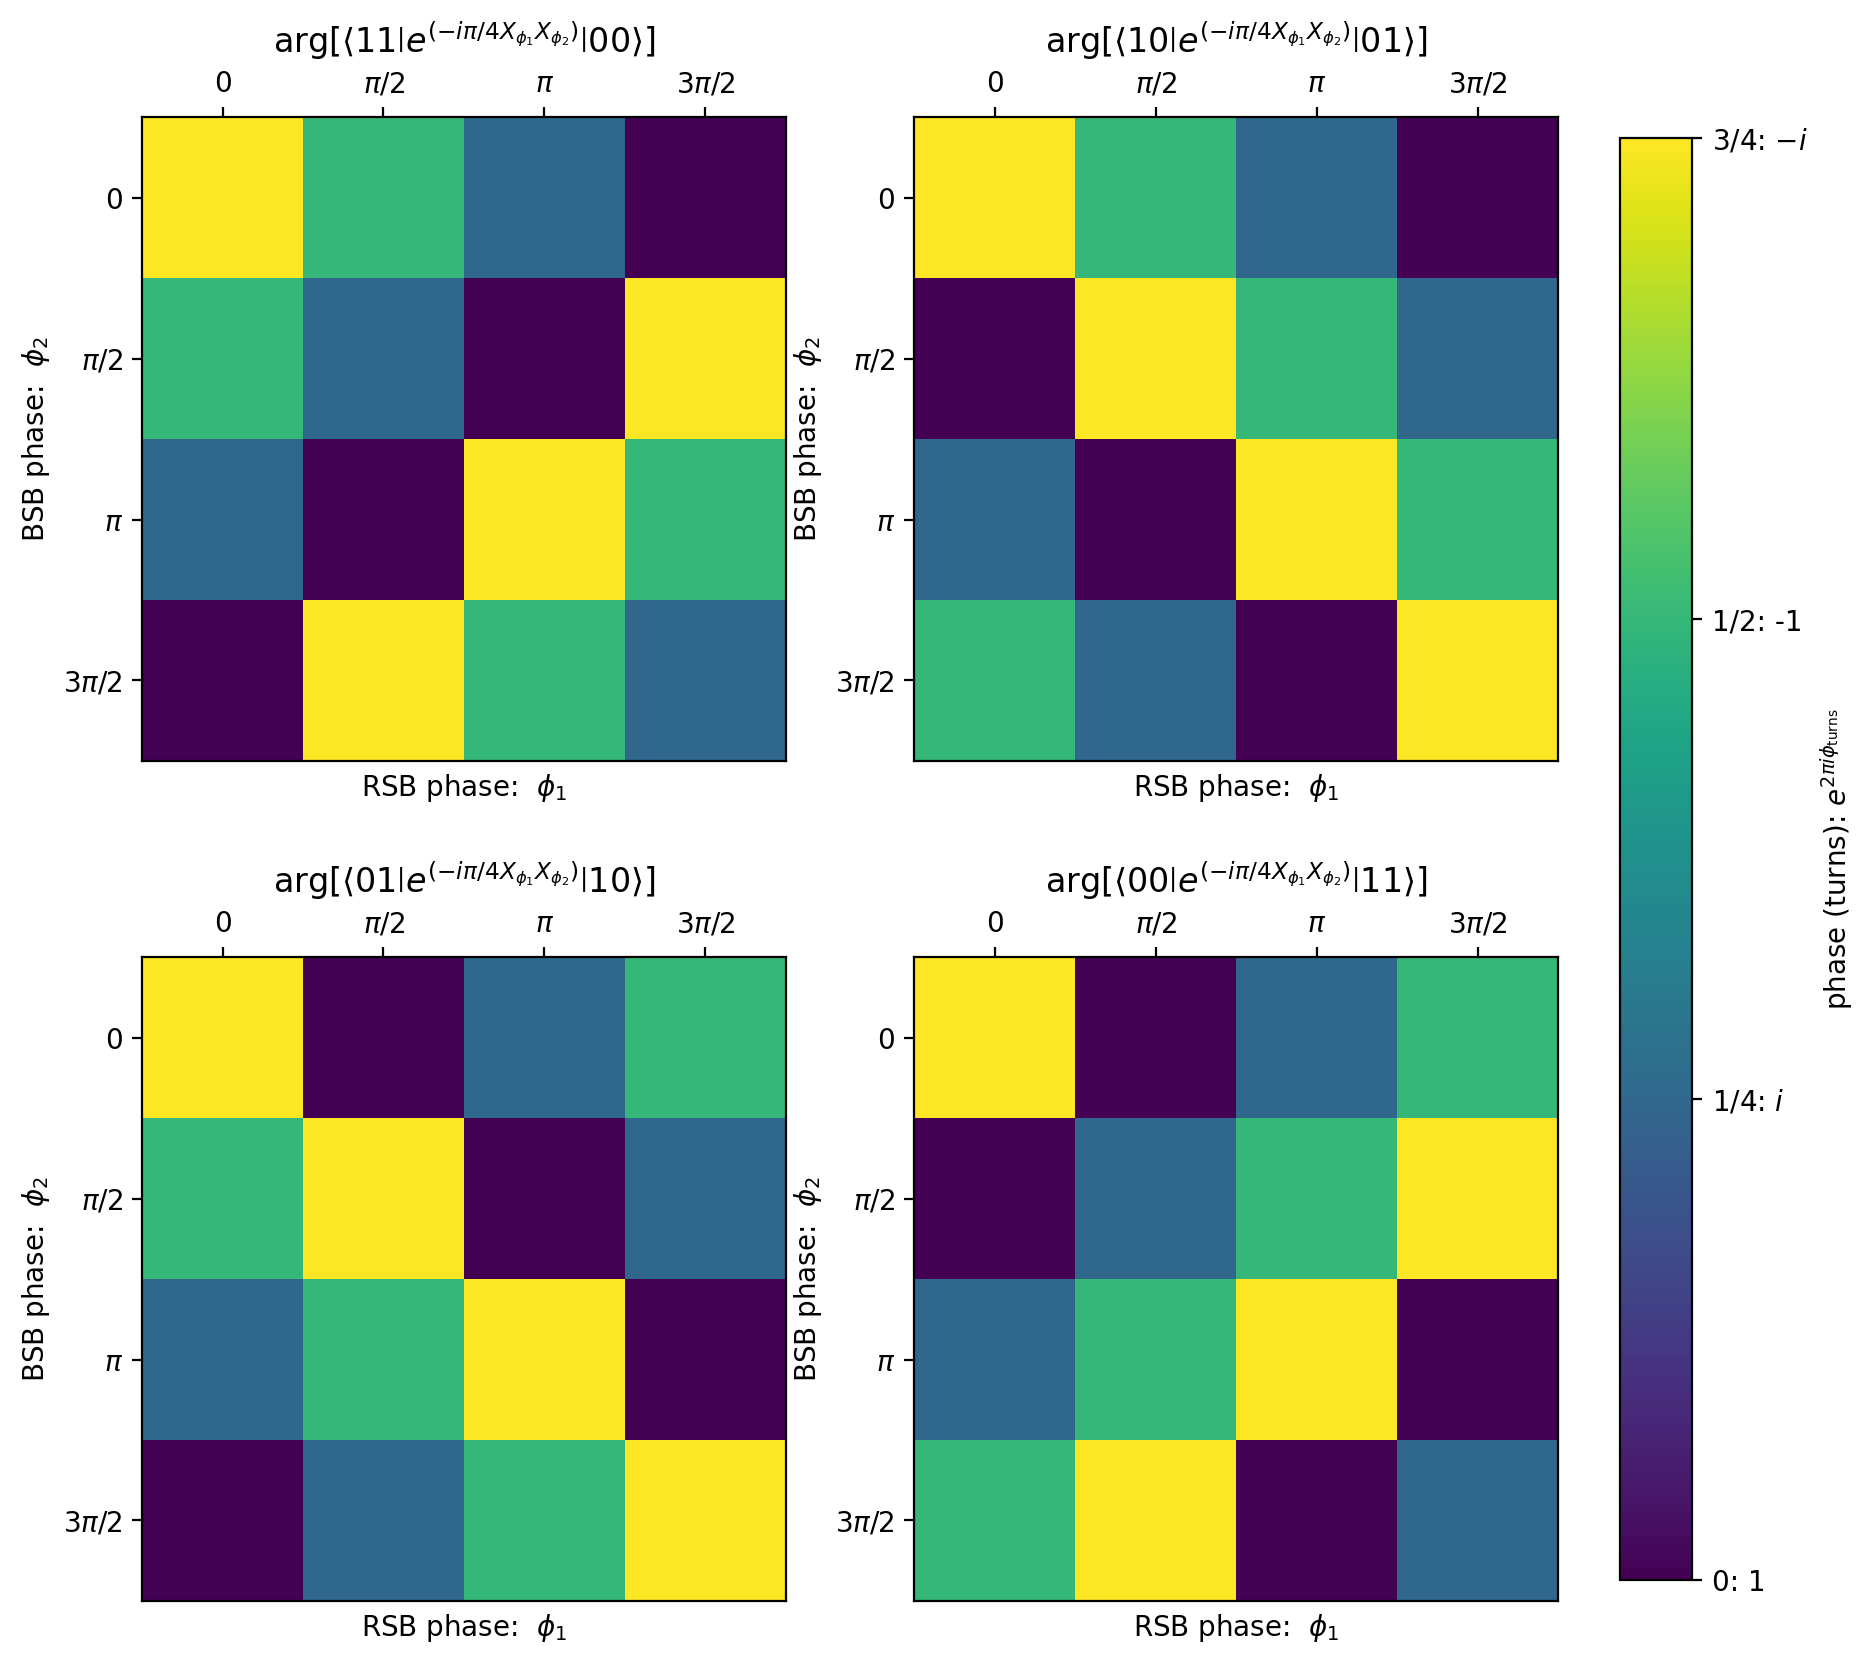

In [137]:
fig, axs = plt.subplots(2,2,figsize=(10,10))
ims = np.zeros(4)
def MS_phase_plot(ax,i,j):
    ij = str(i)+str(j)
    notij = str(int(not i)) + str(int(not j))
    im = ax.imshow((phaseij(i,j)%(2*np.pi))/(2*np.pi))
    ticks = [0,1,2,3]
    ticklabs = ['0', r'$\pi/2$', r'$\pi$',r'$3\pi/2$']
    ax.xaxis.tick_top()
    ax.set_xticks(ticks)
    ax.set_xticklabels(ticklabs)
    ax.set_yticks(ticks)
    ax.set_yticklabels(ticklabs)
    
    # divider = make_axes_locatable(axs[i][j])
    # cax = divider.append_axes("right", size="5%", pad=0.05)
    # cbar = fig.colorbar(im, cax=cax)

    ax.set_xlabel(r'RSB phase:  $\phi_1$',fontsize=10)
    ax.set_ylabel(r'BSB phase:  $\phi_2$',fontsize=10)
    title=r'$\arg[\left<'+notij+r'\right|e^{(-i\pi/4X_{\phi_1}X_{\phi_2})}\left|'+ij+r'\right>]$'
    ax.set_title(title, fontsize=12)

    return im

ims = []
for i in range(2):
    for j in range(2):
        ims.append(MS_phase_plot(axs[i, j], i, j))
# fig.suptitle('MS gate action on 2Q basis states')
cbar = fig.colorbar(ims[0], ax=axs, fraction=0.0465, pad=0.04)
cbar.ax.set_yticks([0,0.25,0.5,0.75])
cbar.ax.set_yticklabels(['0: 1' ,r'1/4: $i$', '1/2: -1', r'3/4: $-i$'])
cbar.ax.set_ylabel(r'phase (turns): $e^{2\pi i\phi_{\text{turns}}}$',fontsize=10)
plt.show()

In [139]:
fname = 'MS-gate-phase'
fig.savefig(fname+'.png',bbox_inches="tight")
fig.savefig(fname+'.pdf',bbox_inches="tight")